<a href="https://colab.research.google.com/github/celinenguyen03/photo-recognition-app/blob/main/Train_YOLO_Models_on_Specific_People.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train YOLO Models in Google Colab
**Author:** Celine Nguyen

**Last updated:** March 3, 2025

**GitHub:** [Train and Deploy YOLO Model for Intelligent Photo Libraries](https://github.com/celinenguyen03/photo-recognition-app)

# Introduction

This notebook uses [Ultralytics](https://docs.ultralytics.com/) to train YOLO11 object detection models with a custom dataset.

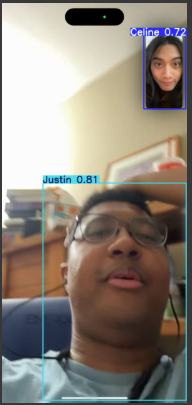

<p>
<i>It can detect us!</i>
</p>

### Credit
Thank you to Ultralytics for the YOLOv open-source code and Evan Juras for the scripts.

### Navigation
To navigate this notebook, use the table of contents in the left sidebar to jump from section to section.



#1.&nbsp;Gather and Label Training Images

Before we start training, we need to gather and label images that will be used for training the object detection model. A good starting point for a proof-of-concept model is 200 images. Since I only have 105 photos total of myself and Justin, the model makes some slight errors. The training images should have random objects in the image along with the desired objects, and should have a variety of backgrounds and lighting conditions.

Things to Note:

*   I built my own custom dataset by taking your own pictures of the objects and labeling them using [Label Studio](https://labelstud.io), which is a free open-source labeling tool.

* The model was trained on 105 images, 63 of me, 19 of justin, and 23 of both of us. Ideally, each training object should have at least 100 pictures of it, but this modeled after real-life, where some people's albums might not have many pictures of themselves, hence the low sample size.

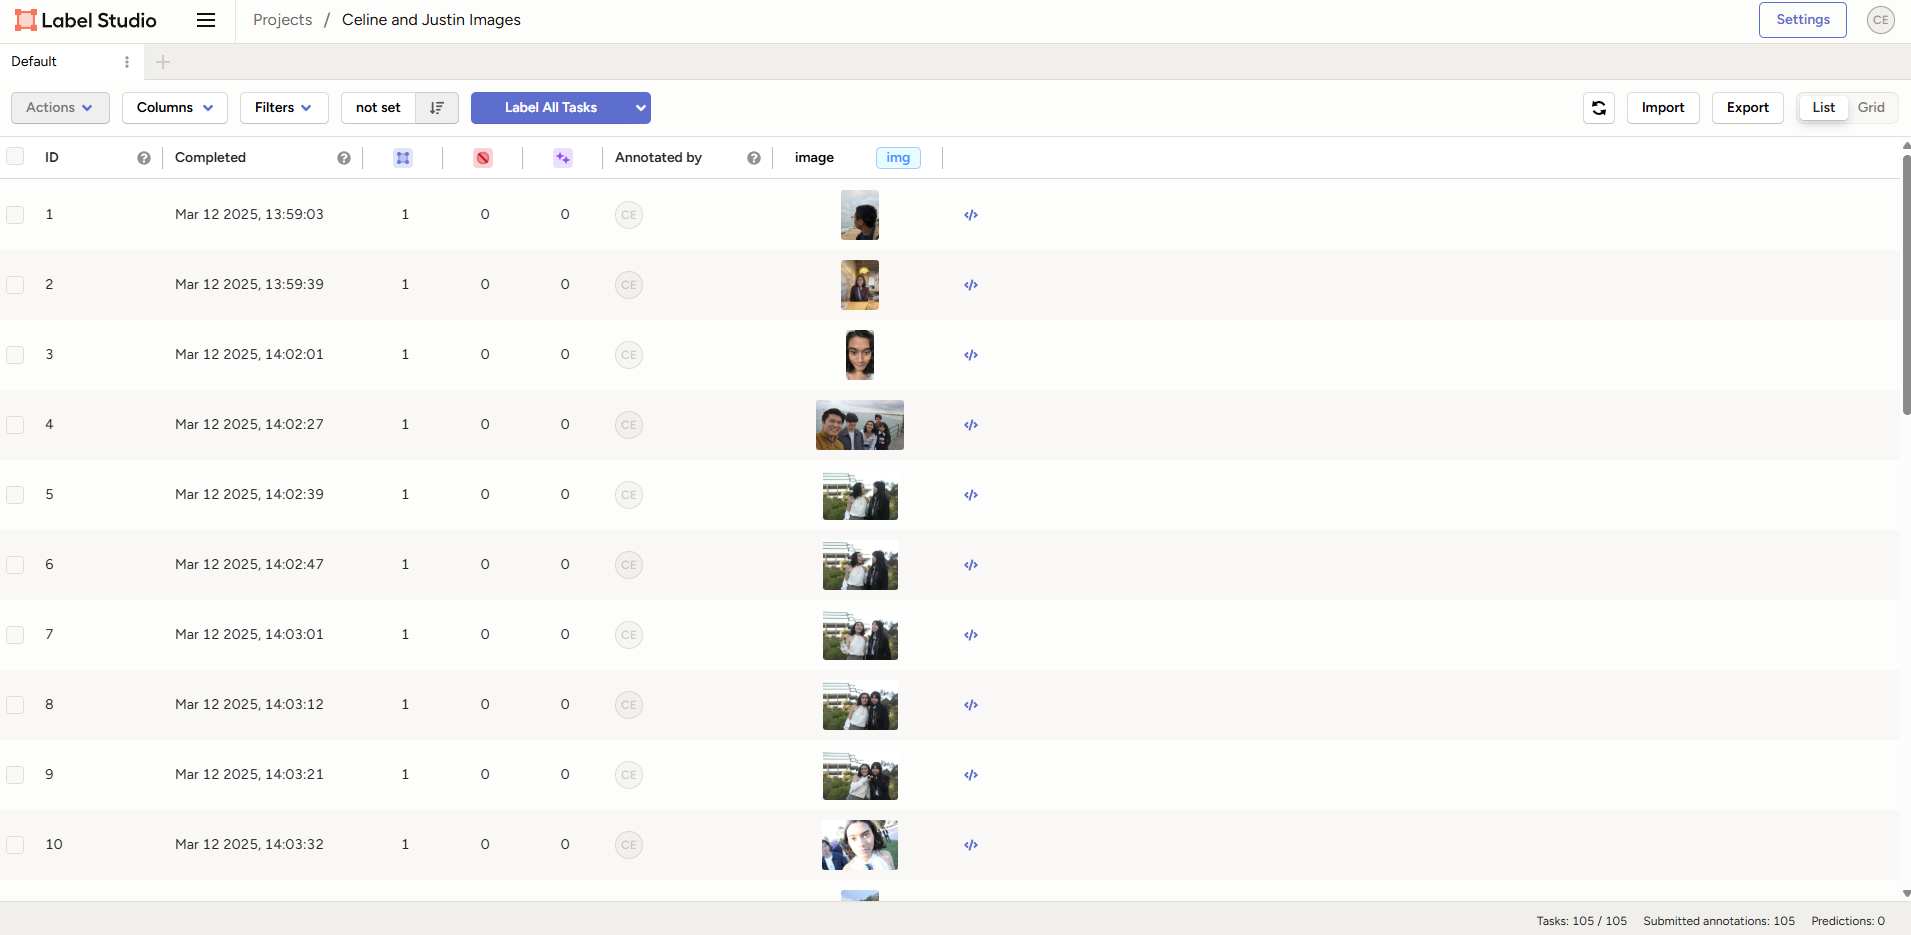
<p>
<i>Label Studio's labeling interface</i>
</p>

Label Studio exported in a `project.zip` file that contains the following:

- An `images` folder containing the images
- A `labels` folder containing the labels in YOLO annotation format
- A `classes.txt` labelmap file that contains all the classes
- A `notes.json` file that contains info specific to Label Studio (this file can be ignored)

After I built the dataset, it's time to prepare it for training!

# 2.&nbsp;Upload Image Dataset and Prepare Training Data

Next, we'll upload our dataset and prepare it for training with YOLO. We'll split the dataset into train and validation folders, and we'll automatically generate the configuration file for training the model.

## 2.1 Upload images

First, we need to upload the dataset to Colab. I moved the `data.zip` folder into this Colab instance.

## 2.2 Split images into train and validation folders

At this point, whether you used Option 1, 2, or 3, you should be able to click the folder icon on the left and see your `data.zip` file in the list of files. Next, we'll unzip `data.zip` and create some folders to hold the images. Run the following code block to unzip the data.

In [ ]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

Ultralytics requires a particular folder structure to store training data for models. Ultralytics requires a particular folder structure to store training data for models. The root folder is named “data”. Inside, there are two main folders:

*   **Train**: These are the actual images used to train the model. In one epoch of training, every image in the train set is passed into the neural network. The training algorithm adjusts the network weights to fit the data in the images.


*   **Validation**: These images are used to check the model's performance at the end of each training epoch.

In each of these folders is a “images” folder and a “labels” folder, which hold the image files and annotation files respectively.

I adapted a Python script from Evan Juras that will automatically create the required folder structure and randomly move 90% of dataset to the "train" folder and 10% to the "validation" folder.

In [ ]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/celinenguyen03/photo-recognition-app/refs/heads/main/utils/train_val_split.py

!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-03-13 20:37:26--  https://raw.githubusercontent.com/celinenguyen03/photo-recognition-app/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-03-13 20:37:26 (34.9 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 105
Number of annotation files: 105
Images moving to train: 94
Images moving to validation: 11


# 3.&nbsp;Install Requirements (Ultralytics)

Next, I'll install the Ultralytics library in this Google Colab instance. This Python library will be used to train the YOLO model.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.6/932.6 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# 4.&nbsp;Configure Training


Run the code block below to automatically generate a `data.yaml` configuration file.

In [ ]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 2
names:
- Celine
- Justin


# 5.&nbsp;Train Model

## 5.1 Training Parameters

**Model architecture & size (`model`):**

I used `yolo11s.pt`, which is fast enough for slow-moving applications and images like my use cases.

**Number of epochs (`epochs`)**

In machine learning, one “epoch” is one single pass through the full training dataset. Setting the number of epochs dictates how long the model will train for. My dataset has less than 200 images, so I went with 60 epochs.


**Resolution (`imgsz`)**

I trained my YOLO modelwith a 640x640 resolution.


## 5.2 Run Training!

In [ ]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 18.4M/18.4M [00:00<00:00, 308MB/s]
Ultralytics 8.3.89 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False,

#6.&nbsp;Test Model

The model has been trained; now it's time to test it! The commands below run the model on the images in the validation folder and then display the results for the first 10 images.

In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

/bin/bash: line 1: yolo: command not found


In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


The model should draw a box around each object of interest in each image. Here are some things to note:

1. Some images in the dataset had slight overlap for labeling due to the objects being very close to each other.
2. Sample size was relatively low, so it is less confident recognizing me with different hair styles.
3. The dataset didn't contain many angles, a lot of the images were forward-facing, so it struggles when the objects turn.

# 7.&nbsp;Conclusion

Overall, I had a lot of fun creating this proof of concept. 😙 It was very fun (and tedious) to individually label each and every image. If I were to make any changes, I would create a function that automatically goes through a person's library and have it auto-detect objects. These can be labeled by the users to account for some of their own niche items or images, like a Pokemon plushie that they always take photos of.

Thanks for taking a look at my notebook and feel free to check out some of my other works at my GitHub:

🌸 https://github.com/celinenguyen03